# Part One: Bandits and Bayesian Testing

<font size="4">**Why should we care about Bayesian testing and bandits?**</font>

Let's talk about traditional A/B testing using an example most RV'ers will be familiar with: the good old website button.

You want to test three different versions of a button on MyVertical dot com. To run the test, you split a 10M audience equally across the three different button options. Finally, you run the test for three weeks to collect data.

Let's say the best performing button had a click-through rate of 10%, whereas the second best only had a rate of 2%. In other words, you just allocated millions of users to the worse options which, in this case, resulted in hundreds of thousands of dollars in opportunity cost. Multiply that cost across dozens of tests throughout a year, and the total opportunity cost could be in the *millions* of dollars! Not good.

The core problem bandits solve - “how do I allocate traffic dynamically to learn and win quickly?” - is the foundation of Journey Optimization. Each “button” becomes a product experience, and the “click” becomes a reward signal. The algorithms mentioned below (epsilon greedy, Thompson sampling) are directly powering the CDAPI contextual bandit engine used in production JO tests.

<br>

<font size="4">**The Idea**</font>

Instead of splitting traffic equally, can we dynamically allocate traffic across buttons in such a way that we discover and exploit the best button while minimizing traffic allocated to suboptimal buttons?

Two algorithms discussed below (epsilon greedy and Thomson sampling) were designed with this in mind!

## 1. Naive Greedy Algorithm

The naive greedy algorithm is as aggressive as it gets: Try all the buttons X times each (where X >= 1), and pick the best performing one. You can think of this as running an incredibly small A/B test and just picking the best performing button (without any stat sig calculation) thereafter.

**TODO:**

**Discuss why a greedy algorithm with X = 1 is a poor algorithm by basically any criteria using a scenario of your construction. (Hint: Is the algorithm even guaranteed to prefer the best button in the long run? Explain why or why not.)**

**<<< Because this result will be hyper senstive to each answer. Because there are no stat sig calculations, randomness wil higfghly affect this algorithm  >>>**


The challenge with the naive greedy solution is that it is excessively greedy and foregoes all exploration in favor of immediate exploitation.

In bandit testing and reinforcement learning, we often face a trade-off between exploration (wanting to collect useful data about various unknown buttons) and exploitation (wanting to divert more traffic towards better-performing buttons.) These two goals are often opposed, hence the "trade-off".

On the extreme of 100% exploration, you get traditional A/B testing (no exploitation.) But on the extreme of 100% exploitation, you get the naive greedy algorithm above (no exploration.) Both extremes are suboptimal in this context, meaning that better algorithms lie somewhere between the two!


## 2. Epsilon Greedy Algorithm

One way to force some exploration into the naive greedy algorithm is to inject a little randomness. We do this with a parameter called "epsilon", hence the name "epsilon greedy".

The algorithm works by picking the greedy option with a probability of (1 - epsilon), and picking a random option with a probability of epsilon (where 0 < epsilon < 1, epsilon = 0 means never explore; epsilon = 1 means always explore)

First, we'll create 3 buttons with different true click-through rate probabilities, as well as a function to simulate serving a particular button once to a user for simulation purposes:

In [1]:
import random

button1_true_ctr = 0.3
button2_true_ctr = 0.5
button3_true_ctr = 0.7

def serve_button(button_id):
    """
    Randomly generate a click from a particular button (Bernoulli distribution) to simulate clicks from serving button.
    """
    rand_num = random.random()
    if button_id == 1:
        # Click with a probability of button1_true_ctr
        return 1 if rand_num < button1_true_ctr else 0
    elif button_id == 2:
        # Click with a probability of button2_true_ctr
        return 1 if rand_num < button2_true_ctr else 0
    elif button_id == 3:
        # Click with a probability of button3_true_ctr
        return 1 if rand_num < button3_true_ctr else 0
    else:
        raise ValueError("Invalid button id")

**TODO:**

**Fill in the missing lines in the function below to implement the epsilon greedy algorithm:**

In [3]:
# TO DO: Fill in the missing lines where prompted (in the comments) within the "epsilon_greedy" function

def epsilon_greedy(num_iterations, epsilon):
    """
    Simulate the epsilon-greedy algorithm for a given number of iterations.
    """
    sessions_by_button = [0, 0, 0]
    clicks_by_button = [0, 0, 0]
    ctr_estimate_by_button = [None, None, None]
    cumulative_reward = 0
    cumulative_reward_by_iteration = []

    # First pass through all buttons to get initial non-null CTR estimates
    for button_id in [1, 2, 3]:
        binary_click = serve_button(button_id)
        idx = button_id - 1
        sessions_by_button[idx] += 1
        clicks_by_button[idx] += binary_click
        ctr_estimate_by_button[idx] = clicks_by_button[idx] / sessions_by_button[idx]

        cumulative_reward += binary_click
        cumulative_reward_by_iteration.append(cumulative_reward)

    # Remaining iterations after initializing all button CTR estimates
    for _ in range(num_iterations - 3):
        if random.random() < epsilon:
            # Setting "button_id" (1, 2, 3) to be random (exploration)
            button_id = random.choice([1, 2, 3])
        else:
            button_id = 1 + max(range(3), key=lambda i: ctr_estimate_by_button[i])


        binary_click = serve_button(button_id)
        idx = button_id - 1
        sessions_by_button[idx] += 1
        clicks_by_button[idx] += binary_click
        ctr_estimate_by_button[idx] = clicks_by_button[idx] / sessions_by_button[idx]


        cumulative_reward += binary_click
        cumulative_reward_by_iteration.append(cumulative_reward)

    return cumulative_reward_by_iteration

Now, we'll use the epsilon greedy function implemented above to plot cumulative clicks (i.e. the cumulative reward) by iteration for each value of epsilon, averaged over multiple trajectories to reduce noise (where each trajectory consists of N complete iterations of an algorithm):

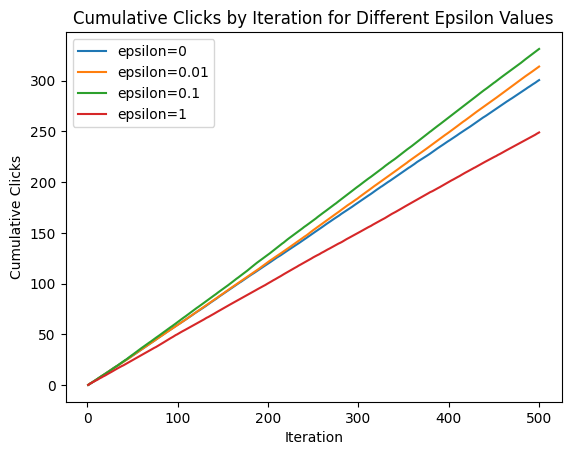

In [4]:
# Run the epsilon greedy algorithm with epsilon=0, epsilon=0.01, epsilon=0.1, and epsilon=1 for 500 iterations
# Repeat 100 times (i.e. create 100 trajectories) to average out over different trajectories

import numpy as np
import matplotlib.pyplot as plt

n_iterations = 500
n_trajectories = 100

avg_reward_by_iteration_epsilon_000 = np.zeros(n_iterations)
avg_reward_by_iteration_epsilon_001 = np.zeros(n_iterations)
avg_reward_by_iteration_epsilon_010 = np.zeros(n_iterations)
avg_reward_by_iteration_epsilon_100 = np.zeros(n_iterations)

for k in range(n_trajectories):
  avg_reward_by_iteration_epsilon_000 += np.array(epsilon_greedy(num_iterations=n_iterations, epsilon=0))
  avg_reward_by_iteration_epsilon_001 += np.array(epsilon_greedy(num_iterations=n_iterations, epsilon=0.01))
  avg_reward_by_iteration_epsilon_010 += np.array(epsilon_greedy(num_iterations=n_iterations, epsilon=0.1))
  avg_reward_by_iteration_epsilon_100 += np.array(epsilon_greedy(num_iterations=n_iterations, epsilon=1))

avg_reward_by_iteration_epsilon_000 = avg_reward_by_iteration_epsilon_000 / n_trajectories
avg_reward_by_iteration_epsilon_001 = avg_reward_by_iteration_epsilon_001 / n_trajectories
avg_reward_by_iteration_epsilon_010 = avg_reward_by_iteration_epsilon_010 / n_trajectories
avg_reward_by_iteration_epsilon_100 = avg_reward_by_iteration_epsilon_100 / n_trajectories

# Plotting the curves

plt.plot(range(1, n_iterations+1), avg_reward_by_iteration_epsilon_000, label='epsilon=0')
plt.plot(range(1, n_iterations+1), avg_reward_by_iteration_epsilon_001, label='epsilon=0.01')
plt.plot(range(1, n_iterations+1), avg_reward_by_iteration_epsilon_010, label='epsilon=0.1')
plt.plot(range(1, n_iterations+1), avg_reward_by_iteration_epsilon_100, label='epsilon=1')

plt.xlabel('Iteration')
plt.ylabel('Cumulative Clicks')
plt.title('Cumulative Clicks by Iteration for Different Epsilon Values')
plt.legend()

plt.show()

**TODO:**

<b>
1. Discuss the results and their implications. Does the number of iterations potentially impact which algorithm you'd choose?
<br>
2. What do epsilon=0 and epsilon=1 represent? And why do you think epsilon=1 is performing poorly?
</b>

**<< Write your text response here >>**

Overall, one drawback to the epsilon greedy algorithm with a constant value of epsilon is that the algorithm continues to randomly explore, even in circumstances where it should be confident about the rewards of the different options and be in full "exploit" mode. Thompson sampling is one algorithm that takes into account this certainty; to set up the algorithm, we'll first briefly review the Bayesian update framework using the beta-binomial model.

## 3. Review of the Bayesian Beta-Binomial Model

We discussed Bayesian priors and posteriors in a previous section, but some intuition review is in order before we proceed to the famous Thompson sampling algorithm.

Run the below code to generate an interactive graph that allows you to play around with:

- The prior belief distribution over an unknown CTR (which we model as a beta distribution w/ its two free parameters of alpha and beta that you can tweak here)
- The true underlying CTR
- The number of sessions we simulate

Choosing different values for the above will generate different posterior belief distributions over the CTR:

In [5]:
from scipy.stats import beta as betadist
from ipywidgets import interact, IntSlider, FloatSlider

def plot_beta_posterior(alpha, beta, p_true, N):
    prior_alpha = alpha
    prior_beta = beta

    # Simulate coin flips
    data = np.random.binomial(1, p_true, N)

    # Calculate posterior
    posterior_alpha = prior_alpha + np.sum(data)
    posterior_beta = prior_beta + N - np.sum(data)

    x = np.linspace(0, 1, 1000)
    prior = betadist.pdf(x, a=prior_alpha, b=prior_beta)
    posterior = betadist.pdf(x, a=posterior_alpha, b=posterior_beta)

    plt.figure(figsize=(12, 6))
    plt.plot(x, prior, label='Prior Belief on CTR', color='blue')
    plt.plot(x, posterior, label='Posterior Belief on CTR', color='red')
    plt.title('Bayesian CTR Update Via Prior')
    plt.xlabel('CTR')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

# Create interactive widget
interact(plot_beta_posterior,
         alpha=FloatSlider(min=1, max=100, step=0.5, value=6, description='Alpha'),
         beta=FloatSlider(min=1, max=100, step=0.5, value=3, description='Beta'),
         p_true=FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, description='True CTR'),
         N=IntSlider(min=1, max=500, step=1, value=1, description='# of Sessions'))

interactive(children=(FloatSlider(value=6.0, description='Alpha', min=1.0, step=0.5), FloatSlider(value=3.0, d…

<function __main__.plot_beta_posterior(alpha, beta, p_true, N)>



<b>
1. What happens when N (the number of sessions) gets larger and larger? Explain.
Due to the law of large numbers, more samples means the sample size will decrease as samples with move towards the center to create a more normal curve, so we expect the curve to be steeper.
2. What happens when the prior distribution is skinny and centered around a different CTR than the true one? Explain.
We need a minimum number of samples if the data doesn't appear normal like in this case to obtain a relatively normal result


## 4. The Thompson Sampling Algorithm

Before discussing Thompson sampling, let's briefly discuss using statistics and uncertainty to do more principled exploration (versus random exploration.)

The idea here is simple: explore buttons with greater uncertainty in the CTRs rather than wasting our exploration on buttons that are confidently bad.

One way to do this is to construct Bayesian posterior distributions on the different buttons' CTRs (much like we did for a single button in the interactive above) and pick the button with the highest 95% percentile CTR from its respective posterior distribution. This 95% percentile captures potential "upside" that we want to explore further. As we explore buttons whose upsides fail to materialize, their distributions will shrink around a lower CTR and we will stop exploring it in favor of buttons with higher upside (whether certain or uncertain.) This flavor of algorithm is called "UCB" (upper confidence bound.)

Another technique that works well in practice is to simply sample a CTR estimate from each button's posterior distribution and pick the button with the highest sample to serve again on the next iteration. This technique is called Thompson sampling.

Below, we will implement Thompson sampling in code and compare its cumulative rewards against those of the epsilon greedy methods we investigated earlier.

**TODO:**

**Fill in the missing lines in the function below to implement the Thompson sampling algorithm:**

In [6]:
def thompson_sampling(num_iterations):
    """
    Simulate the Thompson Sampling algorithm for a given number of iterations.
    """
    successes = [0, 0, 0]
    failures = [0, 0, 0]
    cumulative_reward = 0
    cumulative_reward_by_iteration = []

    for _ in range(num_iterations):
        samples = [random.betavariate(successes[i] + 1, failures[i] + 1) for i in range(3)]
        button_id = 1 + max(range(3), key=lambda i: samples[i])
        reward = serve_button(button_id)
        cumulative_reward += reward
        cumulative_reward_by_iteration.append(cumulative_reward)

        if reward == 1:
            successes[button_id - 1] += 1
        else:
            failures[button_id - 1] += 1

    return cumulative_reward_by_iteration

Now, we'll use the Thompson sampling function implemented above to plot cumulative clicks (i.e. the cumulative reward) by iteration for each value, averaged over multiple trajectories to reduce noise (where each trajectory consists of N complete iterations of an algorithm.) We'll include the average trajectories from the different epsilon greedy strategies above in the plot for comparison:

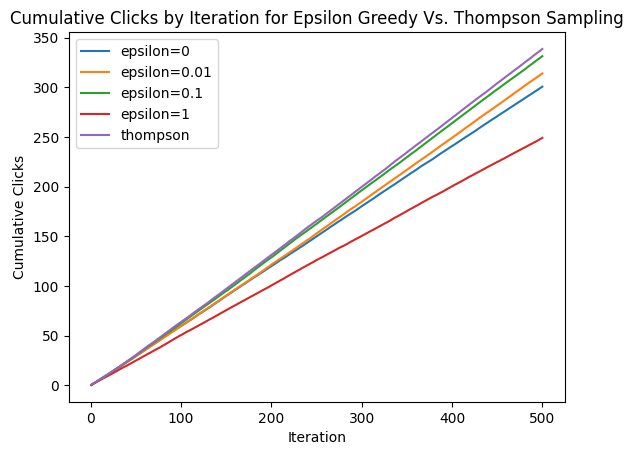

In [7]:
avg_reward_by_iteration_thompson = np.zeros(n_iterations)

for k in range(n_trajectories):
  avg_reward_by_iteration_thompson += np.array(thompson_sampling(num_iterations=n_iterations))

avg_reward_by_iteration_thompson = avg_reward_by_iteration_thompson / n_trajectories

# Plotting the curves

plt.plot(range(1, n_iterations+1), avg_reward_by_iteration_epsilon_000, label='epsilon=0')
plt.plot(range(1, n_iterations+1), avg_reward_by_iteration_epsilon_001, label='epsilon=0.01')
plt.plot(range(1, n_iterations+1), avg_reward_by_iteration_epsilon_010, label='epsilon=0.1')
plt.plot(range(1, n_iterations+1), avg_reward_by_iteration_epsilon_100, label='epsilon=1')
plt.plot(range(1, n_iterations+1), avg_reward_by_iteration_thompson, label='thompson')

plt.xlabel('Iteration')
plt.ylabel('Cumulative Clicks')
plt.title('Cumulative Clicks by Iteration for Epsilon Greedy Vs. Thompson Sampling')
plt.legend()

plt.show()

**TODO:**

<b>
1. Why do you think Thompson sampling often tends to outperform epsilon greedy over the long run? (Hint: Think about the role of epsilon.)
<br>
2. Briefly discuss how you might approach this problem with real-valued (continuous) rewards like revenue rather than binary (0/1) clicks. (Hint: Would the beta-binomial model carry over here? Probably not...)
</b>

**Epsilon is an adjustable parameter which allows the bivariate sampling to be more accurate(I typically use lambda personally so am unfamiliar with this sampling style)**

Finally, it should be noted that Thompson sampling is one of the algorithms that has powered multiple highly successful bandit tests at RV! We will analyze an example RV test in the "Journey Optimization" section in the next part of the assignment.

With that being said, answer these two questions below before continuing onto the next section:

**TODO:**

<b>
1. Are bandit split tests at RV the best thing since sliced bread? (Y/N)
I am on the emdia team so do not use this term but I would assume yes?
2. Is the original data scientist behind RV's bandit tooling a demigod? (Y/N)
yes




# Part Two: RV Journey Optimization Exercise
Now that you've gotten a better sense of how the statistics you've learned come to life, it's time to put that into practice. In this section, you'll do a short analysis of a JO test.

### About the Dataset
The dataset is from a JO test operating on one of our websites. The model is trying to pick between several different product experiences for the user, based on some of their information. The model is rewarded when someone clicks into the product experience.

In the data, there are the following columns:
* session_id = the session where the journey optimization decision was made
* reward = whether the user clicked on the experience, resulting in a 1 (or a 0 if they did not click)
* characteristic = which product experience the user received
* decision_count = if a decision was made for that user
* is_holdout = whether or not the session received the holdout experience (value of 0 or 1)



In [17]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

In [16]:
## TODO: Load in the data ("jo_data.csv") here
df=pd.read_csv('jo_data.csv')
df.head()

,session_id,reward,characteristic,decision_count,is_holdout
0,07dc93bc-c019-4fca-be80-cc6d6cb6c862,0,animated,1,0
1,0cc60df9-d0d0-4d39-be16-b5fbd10a3f9b,0,urgency,1,0
2,141d950f-7801-42c0-b3da-7071bb082287,0,urgency,1,0
3,23bef61d-7e4b-463a-8223-7b2469c55722,0,animated,1,0
4,27e23a7e-bac2-4fb8-b906-bbe8a391621c,0,animated,1,0


### Holdout vs JO Analysis
Let's start by analyzing the serve rates and reward rates for the holdout.

Text(0, 0.5, 'Number of Decisions')

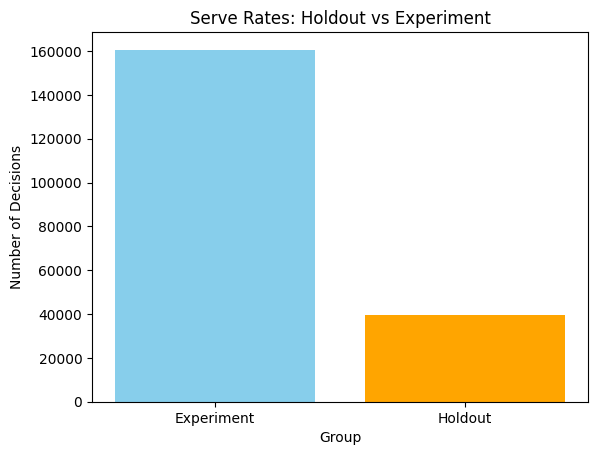

In [18]:
serve_rates = df.groupby("is_holdout")["decision_count"].sum().reset_index()
serve_rates["label"] = serve_rates["is_holdout"].map({0: "Experiment", 1: "Holdout"})
bars = plt.bar(serve_rates["label"], serve_rates["decision_count"], color=["skyblue","orange"])
plt.title("Serve Rates: Holdout vs Experiment")
plt.xlabel("Group")
plt.ylabel("Number of Decisions")


In [19]:
agg = df.groupby("is_holdout").agg(
    total_rewards=("reward", "sum"),
    total_decisions=("decision_count", "sum")
).reset_index()

agg["reward_rate"] = agg["total_rewards"] / agg["total_decisions"]
agg["label"] = agg["is_holdout"].map({0: "Experiment", 1: "Holdout"})

print(agg)


   is_holdout  total_rewards  total_decisions  reward_rate       label
0           0           9328           160638     0.058068  Experiment
1           1           2217            39662     0.055897     Holdout


**TODO:**

<b>
1. Is the holdout or JO performing better? How do you know?
<br>
2. What else would you need to look into next to understand why this is the case?
</b>
Experiment is performing better because it has a higher reward rate, however, we would need to make sure it's statistically significant.

### JO Characteristic Analysis
Now, let's look at the performance by characteristic.

In [23]:
df_experiment = df[df["is_holdout"] == 0].copy()

print(df_experiment.head())
print(f"Remaining rows after removing holdout: {len(df_experiment)}")



                             session_id  reward characteristic  \
0  07dc93bc-c019-4fca-be80-cc6d6cb6c862       0       animated   
1  0cc60df9-d0d0-4d39-be16-b5fbd10a3f9b       0        urgency   
2  141d950f-7801-42c0-b3da-7071bb082287       0        urgency   
3  23bef61d-7e4b-463a-8223-7b2469c55722       0       animated   
4  27e23a7e-bac2-4fb8-b906-bbe8a391621c       0       animated   

   decision_count  is_holdout  
0               1           0  
1               1           0  
2               1           0  
3               1           0  
4               1           0  
Remaining rows after removing holdout: 160638


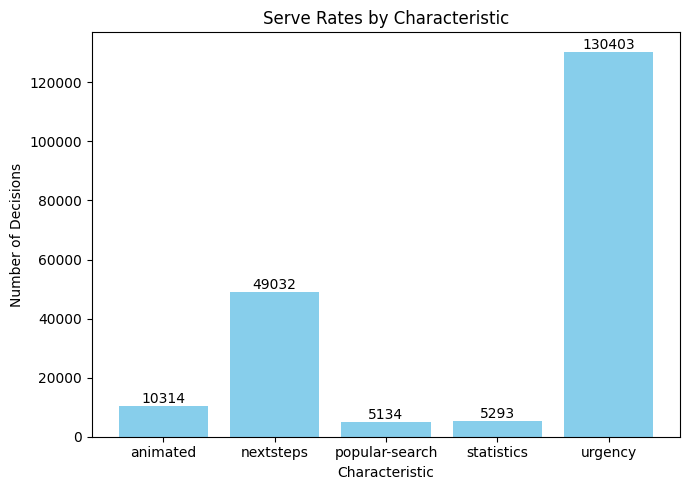

In [24]:
char_serve_rates = df.groupby("characteristic")["decision_count"].sum().reset_index()

plt.figure(figsize=(7,5))
bars = plt.bar(char_serve_rates["characteristic"], char_serve_rates["decision_count"], color="skyblue")
plt.title("Serve Rates by Characteristic")
plt.xlabel("Characteristic")
plt.ylabel("Number of Decisions")

# Annotate counts
for rect, value in zip(bars, char_serve_rates["decision_count"]):
    plt.text(rect.get_x() + rect.get_width()/2.0, value, str(int(value)),
             ha="center", va="bottom")

plt.tight_layout()
plt.show()



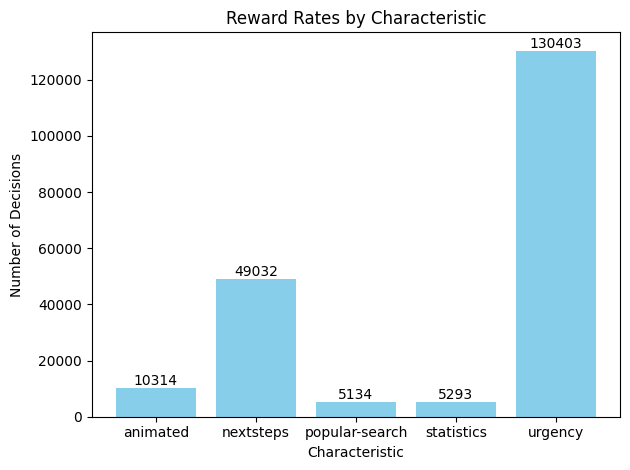

In [25]:
reward_serve_rates = df.groupby("characteristic")["decision_count"].sum().reset_index()

bars = plt.bar(reward_serve_rates["characteristic"], reward_serve_rates["decision_count"], color="skyblue")
plt.title("Reward Rates by Characteristic")
plt.xlabel("Characteristic")
plt.ylabel("Number of Decisions")

for rect, value in zip(bars, char_serve_rates["decision_count"]):
    plt.text(rect.get_x() + rect.get_width()/2.0, value, str(int(value)),
             ha="center", va="bottom")

plt.tight_layout()
plt.show()



**TODO:**

<b>
1. Which experience has the highest reward rate?
<br>
2. Which experience has the lowest reward rate?
<br>
3. Do the serve rates match the rewards the way you'd expect them to?
<br>
4. What additional steps could you take to understand the performance of these different experiences and why JO might be serving one more than the other?
</b>

urgency has the highest reward rate

## Submission

Download completed **Week4_JO_Homework.ipynb** from Google Colab and commit to your personal Github repo you shared with the faculty.